# **01 - Exploratory Data Analysis**


This notebook performs exploratory analysis to understand the statistical behavior of prices, returns, and realized volatility. This provides intuition for time-series dependence, volatility clustering, and non-normality, all of which will guide the modeling choices later in the project.

All plots generated in this notebook are saved under `results/figures/eda/` for documentation and later model comparison.


In [3]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import skew, kurtosis, shapiro, jarque_bera

In [4]:
# Paths
PROCESSED_DIR = Path("../data/processed")
FIG_DIR = Path("../results/figures/eda")

FIG_DIR.mkdir(parents=True, exist_ok=True)

# Load data
df = pd.read_csv(PROCESSED_DIR / "modeling_dataset.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,log_return,rv_21
0,2000-02-02,1409.280029,1420.609985,1403.489990,1409.119995,1409.119995,1038600000,-0.000114,0.016190
1,2000-02-03,1409.119995,1425.780029,1398.520020,1424.969971,1424.969971,1146500000,0.011185,0.013915
2,2000-02-04,1424.969971,1435.910034,1420.630005,1424.369995,1424.369995,1045100000,-0.000421,0.013915
3,2000-02-07,1424.369995,1427.150024,1413.329956,1424.239990,1424.239990,918100000,-0.000091,0.013916
4,2000-02-08,1424.239990,1441.829956,1424.239990,1441.719971,1441.719971,1047700000,0.012198,0.012880


## **Price Trend**

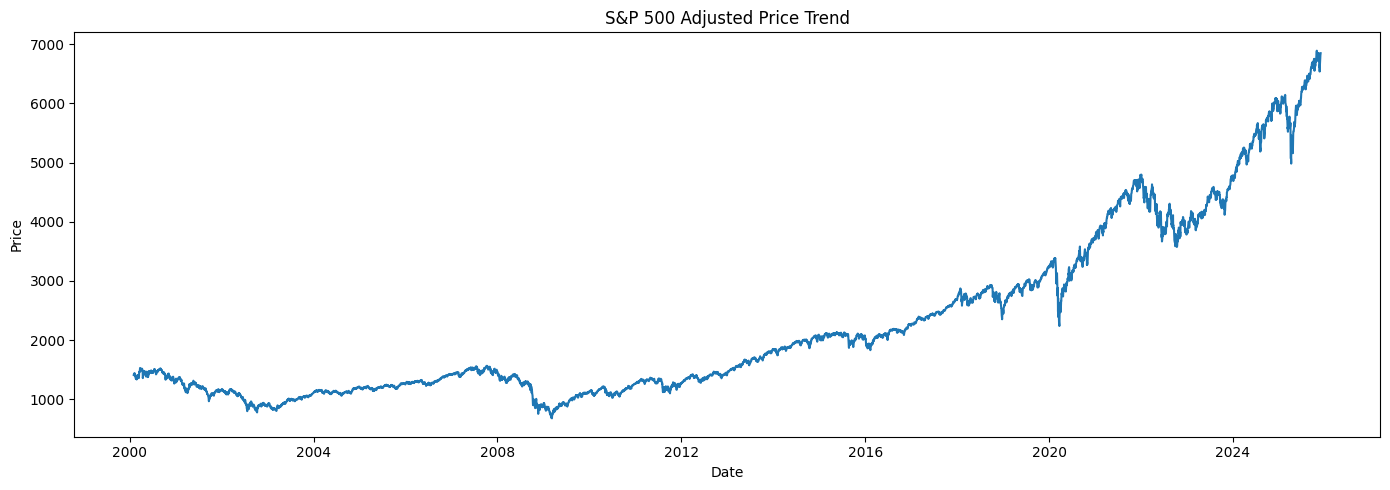

In [5]:
plt.figure(figsize=(14,5))
plt.plot(df['Date'], df['Adj Close'])
plt.title("S&P 500 Adjusted Price Trend")
plt.xlabel("Date")
plt.ylabel("Price")
plt.tight_layout()
plt.savefig(FIG_DIR / "price_trend.png")
plt.show()

Equity index levels contain no stationary structure and cannot be modeled directly. This plot confirms the need to operate on returns rather than prices.

## **Log Returns**

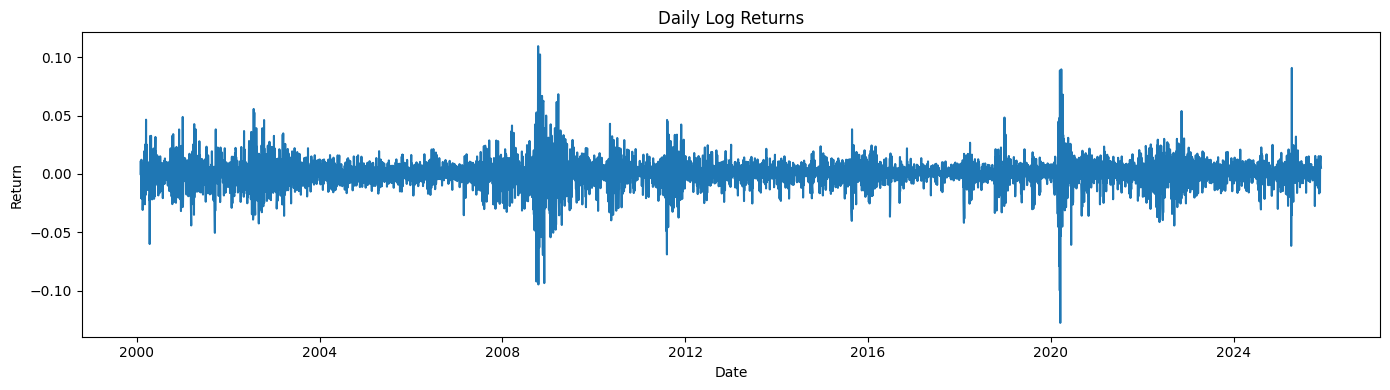

In [6]:
plt.figure(figsize=(14, 4))
plt.plot(df["Date"], df["log_return"])
plt.title("Daily Log Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.tight_layout()
plt.savefig(FIG_DIR / "log_returns_series.png")
plt.show()


The log return series appears noisy and mean-reverting around zero.
Large spikes indicate market stress periods. which later show up in volatility.

## **Histogram and Distribution Diagnostics**

Financial returns are known to be non-normal with heavy tails. This section examines the distribution properties of log returns, including skewness, kurtosis, and normality tests.

## Normality Tests

In [7]:
jb_stat, jb_p = jarque_bera(df["log_return"])
sw_stat, sw_p = shapiro(df["log_return"].sample(5000, random_state=42))  # large samples cause Shapiro errors

print("Jarque-Bera test:")
print("  Statistic:", jb_stat)
print("  p-value:", jb_p)
print("\nShapiro-Wilk test (5000-sample):")
print("  Statistic:", sw_stat)
print("  p-value:", sw_p)


Jarque-Bera test:
  Statistic: 30959.42122521885
  p-value: 0.0

Shapiro-Wilk test (5000-sample):
  Statistic: 0.8949053511504012
  p-value: 4.747482919453275e-50


Both tests reject normality at any reasonable significance level. This is expected for financial returns and motivates using heteroskedastic models rather than constant-variance assumptions.

## Skewness and Kurtosis

In [8]:
sk = skew(df["log_return"])
kt = kurtosis(df["log_return"], fisher=False)

print("Skewness:", sk)
print("Kurtosis:", kt)


Skewness: -0.3462430714017123
Kurtosis: 13.672514280372502


## Histogram of Log Returns

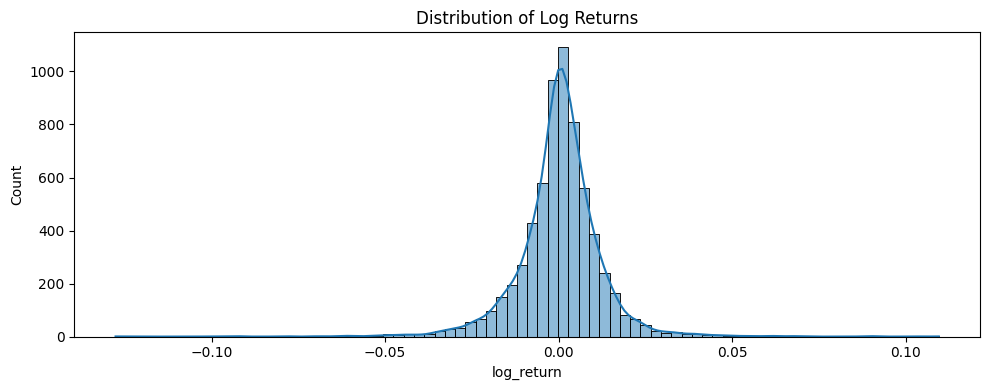

In [9]:
plt.figure(figsize=(10, 4))
sns.histplot(df["log_return"], bins=80, kde=True)
plt.title("Distribution of Log Returns")
plt.tight_layout()
plt.savefig(FIG_DIR / "log_returns_hist.png")
plt.show()


The heavy-tailed distribution in the log-scaled histogram, confirmed by kurtosis > 3 further affirms that Gaussian models are inappropriate. This justifies models such as GARCH or neural networks that can capture non-Gaussian variance structure.

## Tail Risk and Extreme Moves

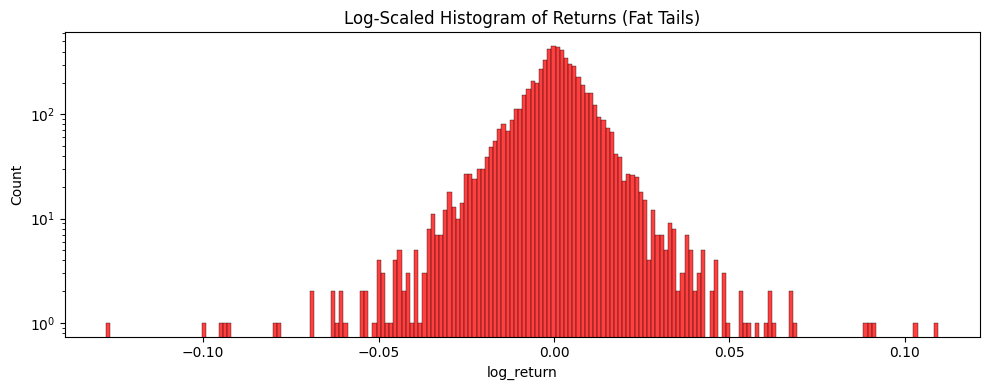

In [10]:
plt.figure(figsize=(10, 4))
sns.histplot(df["log_return"], bins=200, color="red")
plt.yscale("log")
plt.title("Log-Scaled Histogram of Returns (Fat Tails)")
plt.tight_layout()
plt.savefig(FIG_DIR / "log_returns_fat_tails.png")
plt.show()


## Realized Volatility

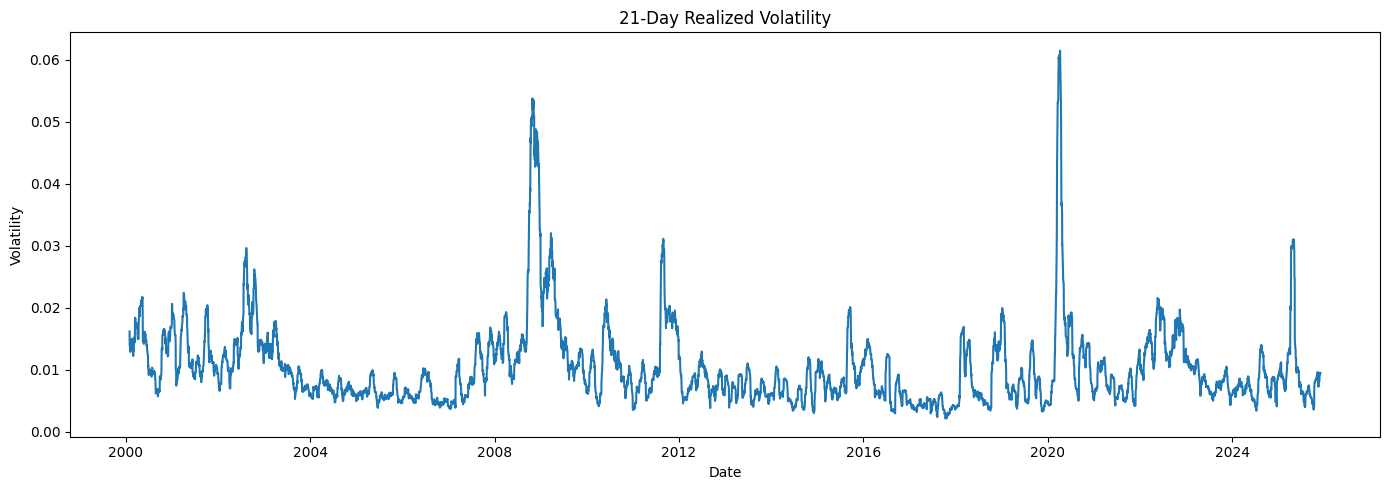

In [11]:
plt.figure(figsize=(14, 5))
plt.plot(df["Date"], df["rv_21"])
plt.title("21-Day Realized Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.tight_layout()
plt.savefig(FIG_DIR / "realized_volatility_series.png")
plt.show()


Clustered spikes correspond to known crisis periods. The persistence and slow decay in volatility support the use of autoregressive conditional variance models such as GARCH and long-memory neural architectures like LSTMs.

## Rolling Volatility

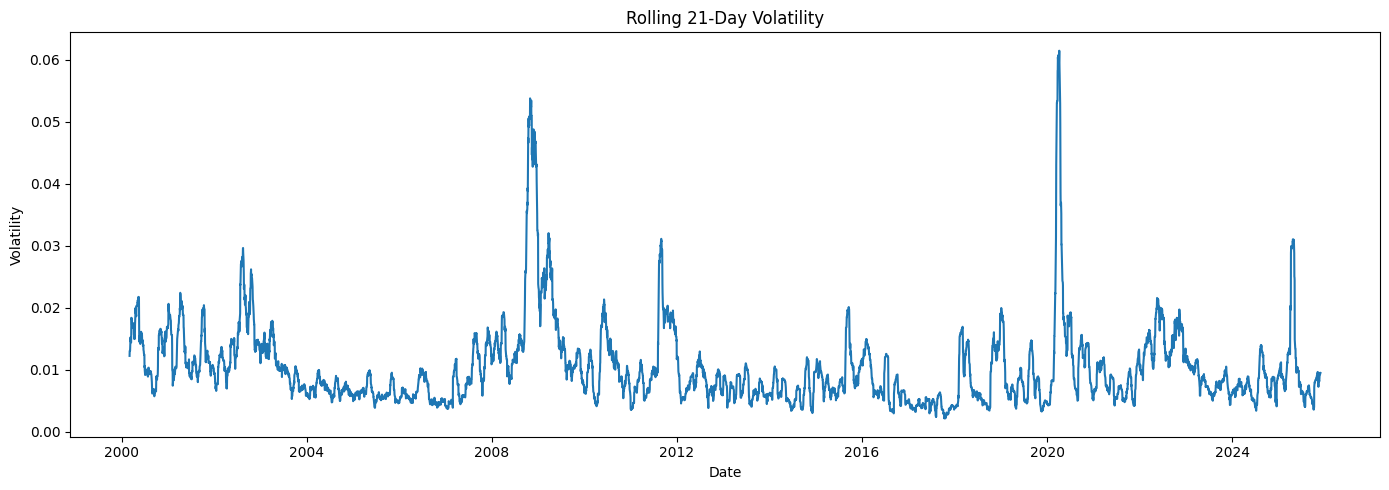

In [12]:
plt.figure(figsize=(14, 5))
plt.plot(df["Date"], df["log_return"].rolling(21).std())
plt.title("Rolling 21-Day Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.tight_layout()
plt.savefig(FIG_DIR / "rolling_volatility.png")
plt.show()


The rolling standard deviation shows clear mean-reverting behavior: volatility rises sharply during crises and slowly decays afterwards. This reinforces the presence of volatility clustering.

## Volatility Clustering Visualization

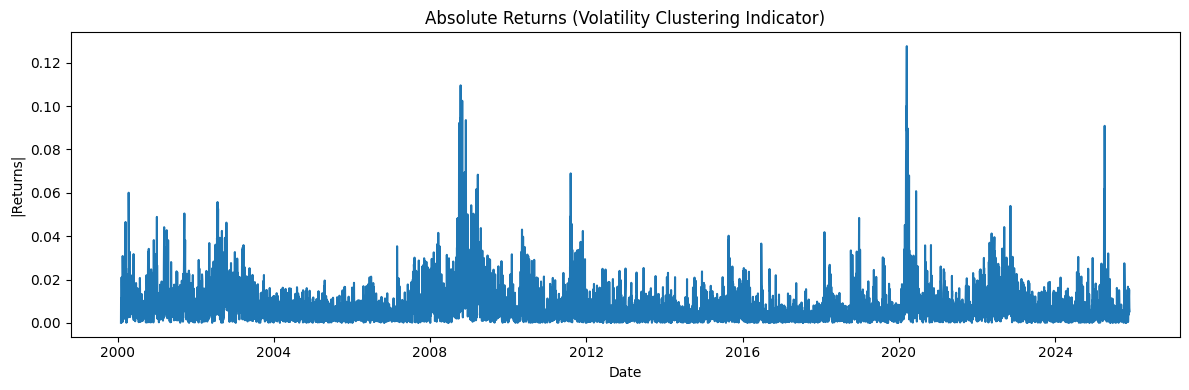

In [13]:
plt.figure(figsize=(12, 4))
plt.plot(df["Date"], np.abs(df["log_return"]))
plt.title("Absolute Returns (Volatility Clustering Indicator)")
plt.xlabel("Date")
plt.ylabel("|Returns|")
plt.tight_layout()
plt.savefig(FIG_DIR / "volatility_clustering.png")
plt.show()

Absolute returns exhibit persistence. High-volatility days tend to occur in streaks, a hallmark of ARCH/GARCH behavior. This visually confirms heteroskedasticity.

## **Autocorrelation Structure**

The autocorrelation structure of returns and squared returns reveals time dependence. This is important for selecting models like GARCH or LSTM, which rely on such patterns.

## ACF of Returns

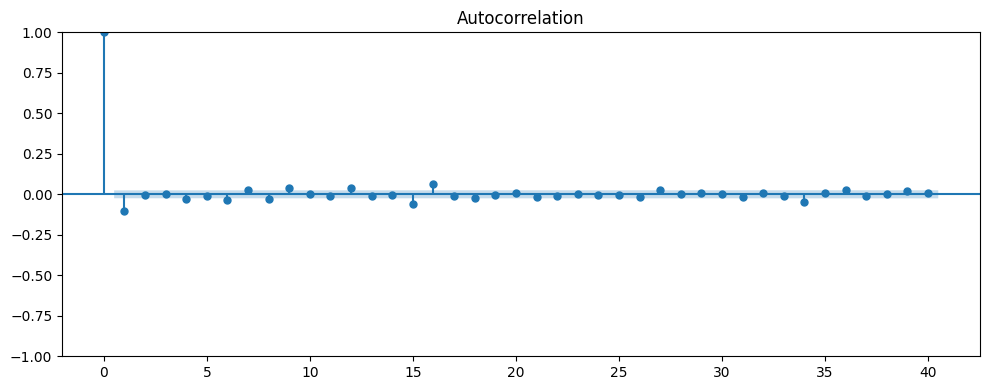

In [14]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(df["log_return"], ax=ax, lags=40)
plt.tight_layout()
plt.savefig(FIG_DIR / "acf_log_returns.png")
plt.show()


Returns autocorrelation is near zero for most lags, indicating that returns are largely memoryless and unsuitable for autoregressive forecasting. This aligns with the efficient market hypothesis.

## ACF of Squared Returns

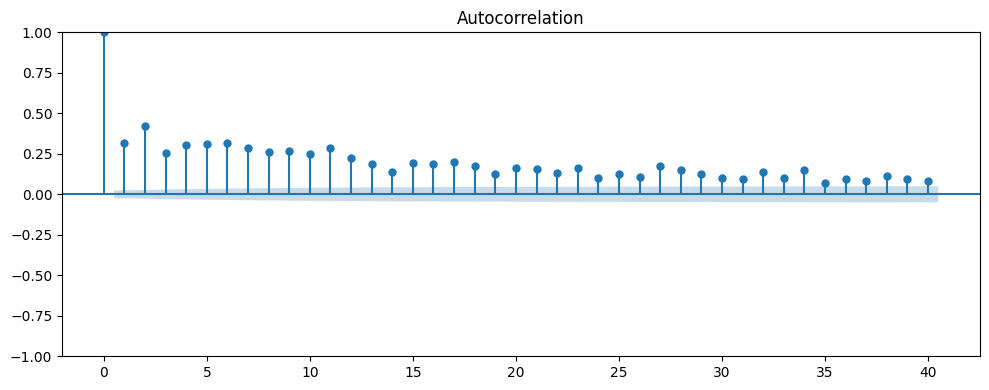

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(df["log_return"] ** 2, ax=ax, lags=40)
plt.tight_layout()
plt.savefig(FIG_DIR / "acf_squared_returns.png")
plt.show()


Squared return autocorrelation decays slowly, indicating long memory in volatility. This feature directly motivates models like GARCH(1,1) and LSTM that use lagged variance/volatility as predictors.

## PACF of Returns

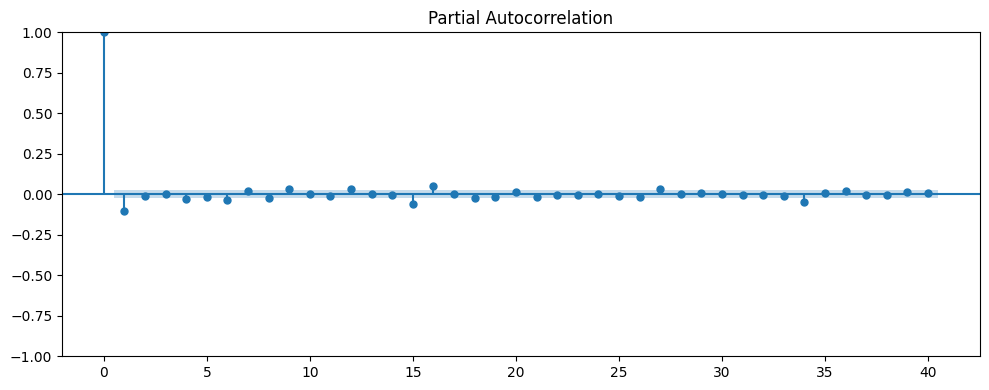

In [16]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_pacf(df["log_return"], ax=ax, lags=40, method='ywm')
plt.tight_layout()
plt.savefig(FIG_DIR / "pacf_log_returns.png")
plt.show()


No significant partial autocorrelations support the interpretation that returns have limited predictive structure. Instead, volatility must be modeled indirectly through variance dynamics.

## **Correlation Between |Returns| and RV**

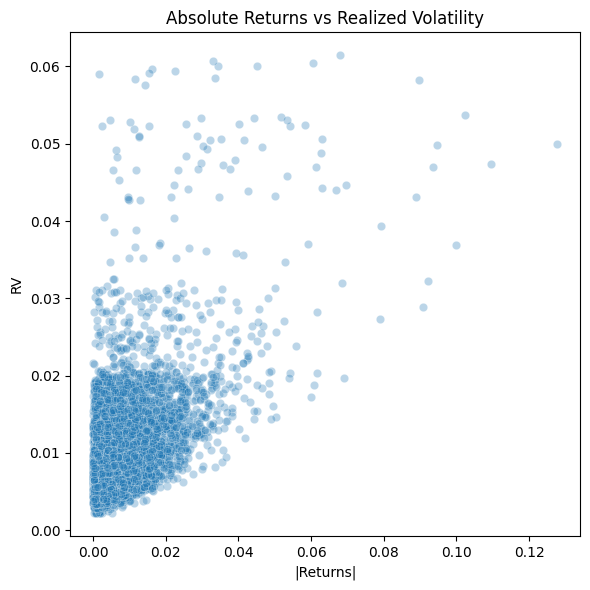

In [17]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=np.abs(df["log_return"]), y=df["rv_21"], alpha=0.3)
plt.title("Absolute Returns vs Realized Volatility")
plt.xlabel("|Returns|")
plt.ylabel("RV")
plt.tight_layout()
plt.savefig(FIG_DIR / "abs_returns_vs_rv.png")
plt.show()


A strong positive relationship is visible between |returns| and realized volatility. This supports using absolute returns as an additional engineered feature for multivariate deep learning models.

## **Leverage Effect Analysis**

In [18]:
df_temp = df[["log_return", "rv_21"]].dropna().copy()
df_temp["rv_next"] = df_temp["rv_21"].shift(-1)
df_temp["sign"] = np.where(df_temp["log_return"] > 0, "Positive", "Negative")

neg_mean = df_temp[df_temp["sign"]=="Negative"]["rv_next"].mean()
pos_mean = df_temp[df_temp["sign"]=="Positive"]["rv_next"].mean()

print("=== Leverage Effect ===")
print(f"Mean next-day volatility after NEGATIVE returns: {neg_mean:.5f}")
print(f"Mean next-day volatility after POSITIVE returns: {pos_mean:.5f}")


=== Leverage Effect ===
Mean next-day volatility after NEGATIVE returns: 0.01055
Mean next-day volatility after POSITIVE returns: 0.01012


Negative returns tend to be followed by higher next-day volatility, a classic leverage effect in equity markets.  <br> 
This asymmetry is important for modeling equity index volatility.


## **Regime Highlighting**

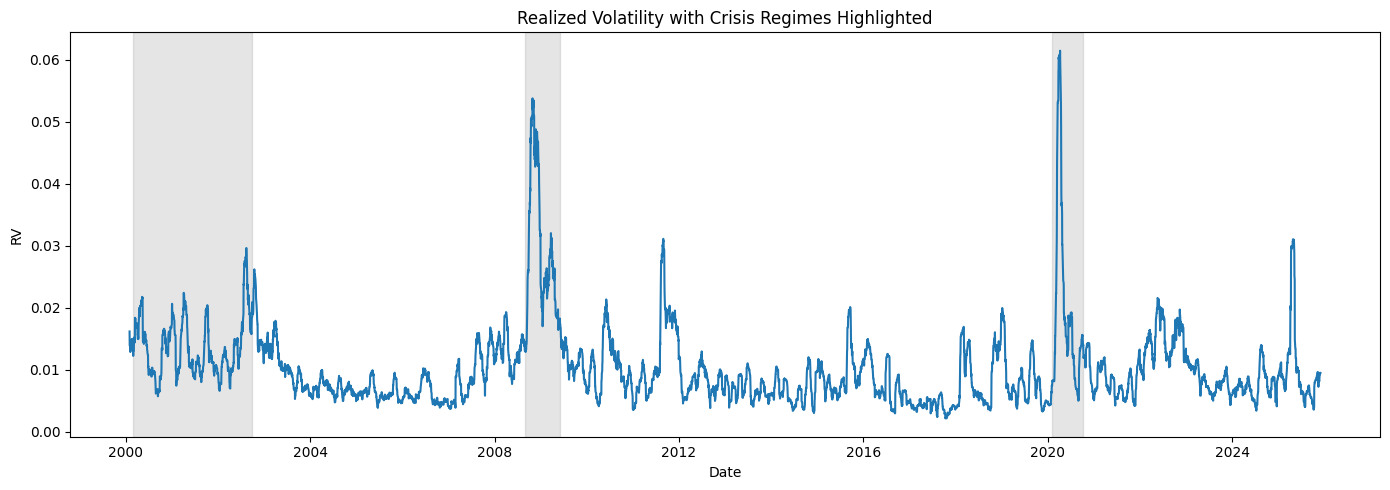

In [19]:
plt.figure(figsize=(14, 5))
plt.plot(df["Date"], df["rv_21"], label="RV_21")

# Shade major known crises
crises = [
    ("2000-03-01", "2002-10-01"),
    ("2008-09-01", "2009-06-01"),
    ("2020-02-01", "2020-10-01")
]

for start, end in crises:
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color="gray", alpha=0.2)

plt.title("Realized Volatility with Crisis Regimes Highlighted")
plt.xlabel("Date")
plt.ylabel("RV")
plt.tight_layout()
plt.savefig(FIG_DIR / "rv_regimes.png")
plt.show()


To better understand volatility spikes, major historical stress periods are shaded. Each volatility spike lines up with major macroeconomic crises:


*   2000-2002:    dot-com collapse
*   2008-2009:    global financial crisis
*   2020:    COVID crash

This validates that the constructed realized volatility measure correctly captures market stress periods.



## Crisis Period Analysis

In [20]:
crisis_periods = {
    "Dot-Com": ("2000-03-01", "2002-10-01"),
    "GFC": ("2007-10-01", "2009-03-01"),
    "COVID": ("2020-02-01", "2020-10-01")
}

print("\n=== Crisis Period Statistics ===")
for name, (start, end) in crisis_periods.items():
    crisis = df[(df["Date"] >= start) & (df["Date"] <= end)]
    print(f"{name}:")
    print(f"  Mean RV: {crisis['rv_21'].mean():.5f}")
    print(f"  Max RV:  {crisis['rv_21'].max():.5f}")
    print(f"  Mean |Return|: {abs(crisis['log_return']).mean():.5f}")



=== Crisis Period Statistics ===
Dot-Com:
  Mean RV: 0.01365
  Max RV:  0.02965
  Mean |Return|: 0.01100
GFC:
  Mean RV: 0.02008
  Max RV:  0.05377
  Mean |Return|: 0.01611
COVID:
  Mean RV: 0.02057
  Max RV:  0.06145
  Mean |Return|: 0.01662


These statistics confirm that realized volatility spikes sharply during known market stress periods.  <br> 
The Dot-Com crash, Global Financial Crisis, and COVID shock all show elevated mean and maximum volatility.


## **Stylized Facts of S&P 500 Returns**

Financial returns exhibit several well-known statistical properties that guide volatility modeling. 
This dataset reflects these classic stylized facts:

• **Zero mean**: Average log returns are very close to zero.  
• **Heavy tails**: Kurtosis is much larger than 3, indicating extreme-value risk.  
• **No autocorrelation in returns**: ACF of raw returns is near zero for most lags.  
• **Volatility clustering**: ACF of squared returns decays slowly, indicating long persistence.  


In [21]:
print("Mean return:", df["log_return"].mean())
print("Kurtosis:", kurtosis(df["log_return"], fisher=False))
print("ACF(Returns)[1]:", df["log_return"].autocorr(lag=1))
print("ACF(Squared Returns)[1]:", (df["log_return"]**2).autocorr(lag=1))

Mean return: 0.00024338620958436056
Kurtosis: 13.672514280372502
ACF(Returns)[1]: -0.1002212021939724
ACF(Squared Returns)[1]: 0.3137115503420778


## **Summary of Insights**

* Returns are heavy-tailed and strongly non-normal.
* Volatility shows clear clustering and long memory.
* Returns have low autocorrelation, but squared returns have persistent correlation.
* Realized volatility aligns with known economic crises.
* These properties motivate the use of:
   - GARCH models for volatility clustering
   - LSTMs for long-range dependence
   - Transformers for capturing non-linear temporal structure

These insights guide all modeling decisions in the rest of the project.
